In [1]:
# Do all relevant imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
import time
import scipy
import tables as tb
%matplotlib inline
print("Libs imported.")

Libs imported.


In [2]:
## Support functions

import matplotlib.pyplot as plt
%matplotlib inline
def plot_coo_matrix(m, size = 0.004):
    if not isinstance(m, sps.coo_matrix):
        m = sps.coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='green', ms=size)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, sps.csc_matrix):
        print("Converting into %s, might be inefficient!" %format)
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, sps.csr_matrix):
        print("Converting into %s, might be inefficient!" %format)
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, sps.coo_matrix):
        print("Converting into %s, might be inefficient!" %format)
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, sps.dok_matrix):
        print("Converting into %s, might be inefficient!" %format)
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, sps.bsr_matrix):
        print("Converting into %s, might be inefficient!" %format)
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, sps.dia_matrix):
        print("Converting into %s, might be inefficient!" %format)
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, sps.lil_matrix):
        print("Converting into %s, might be inefficient!" %format)
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)
def pt():
    #Prints current time
    print("%s:%s"%(time.gmtime().tm_hour+1,time.gmtime().tm_min))


In [3]:
class Matrix_multiplicator(object): 
    def __init__(self):
        self.bl = 500 #this is the number of rows we calculate each loop
    
    def dot(self, m1, m2, filename, result_format = 'csr'): 
        starttime = time.time()
        m1 = check_matrix(m1, 'csr')
        m2 = check_matrix(m2, 'csc')
        
        l, m, n = m1.shape[0], m1.shape[1], m2.shape[1]

        self.f = tb.open_file(filename, 'w')
        filters = tb.Filters(complevel=5, complib='blosc')
        
        out_data = self.f.create_earray(self.f.root, 'data', tb.Float32Atom(), shape=(0,), filters=filters)
        out_indices = self.f.create_earray(self.f.root, 'indices', tb.Int64Atom(),shape=(0,), filters=filters)
        out_indptr = self.f.create_earray(self.f.root, 'indptr', tb.Int64Atom(), shape=(0,), filters=filters)
        out_indptr.append(np.array([0])) #this is needed as a first indptr
        max_indptr = 0
        print("Heading into loop. %s sec"%(time.time()-starttime))
        cp = time.time()
        for i in range(0, l, self.bl):
            if i % 2500 == 0 or i == 500: 
                print("Row %s out of %s, %s min."%(i, l, (time.time()-cp)/60))
                cp = time.time()
            res = m1[i:min(i+self.bl, l),:].dot(m2)
            out_data.append(res.data)
            indices = res.indices
            indptr = res.indptr
            out_indices.append(indices)
            out_indptr.append(max_indptr+indptr[1:])
            max_indptr += indices.shape[0]
            
        if result_format == 'csr': 
            m = sps.csr_matrix((self.f.root.data[:], self.f.root.indices[:], self.f.root.indptr[:]), shape=(l,n))
        elif result_format == 'csc': 
            m = sps.csc_matrix((self.f.root.data[:], self.f.root.indices[:], self.f.root.indptr[:]), shape=(l,n))
        
        self.f.close()
        print("Calculated m.dot() to %s. %s sec" %(filename, time.time()-starttime))
        
    def plus(self, m, scalar, filename, result_format = 'csr'): 
        starttime = time.time()
        m1 = check_matrix(m1, 'csr')
        
        l, m, n = m1.shape[0], m1.shape[1], m2.shape[1]

        self.f = tb.open_file(filename, 'w')
        filters = tb.Filters(complevel=5, complib='blosc')
        
        out_data = self.f.create_earray(self.f.root, 'data', tb.Float32Atom(), shape=(0,), filters=filters)
        out_indices = self.f.create_earray(self.f.root, 'indices', tb.Int32Atom(),shape=(0,), filters=filters)
        out_indptr = self.f.create_earray(self.f.root, 'indptr', tb.Int32Atom(), shape=(0,), filters=filters)
        out_indptr.append(np.array([0])) #this is needed as a first indptr
        max_indptr = 0
        
        for i in range(0, l, self.bl):
            res = m1[i:min(i+self.bl, l),:]
            res.data += scalar
            out_data.append(res.data)
            indices = res.indices
            indptr = res.indptr
            out_indices.append(indices)
            out_indptr.append(max_indptr+indptr[1:])
            max_indptr += indices.shape[0]
            
        if result_format == 'csr': 
            m = sps.csr_matrix((self.f.root.data[:], self.f.root.indices[:], self.f.root.indptr[:]), shape=(l,n))
        elif result_format == 'csc': 
            m = sps.csc_matrix((self.f.root.data[:], self.f.root.indices[:], self.f.root.indptr[:]), shape=(l,n))
        
        self.f.close()
        print("Calculated m.dot() to %s. %s sec" %(filename, time.time()-starttime))
            
    def get_result(self, filename, l, n, result_format = 'csr'):
        h5 = tb.open_file(filename, 'r')
        if result_format == 'csr':
            m = sps.csr_matrix((h5.root.data[:], h5.root.indices[:], h5.root.indptr[:]), shape=(l,n))
        elif result_format == 'csc': 
            m = sps.csc_matrix((h5.root.data[:], h5.root.indices[:], h5.root.indptr[:]), shape=(l,n))
        h5.close()
        return m
m = Matrix_multiplicator()

In [4]:
#a = sps.rand(10,10, format='csr') #imagine that many values are stored in this matrix and that sparsity is low
#a = sps.csr_matrix([[1,0,2],[2,1,0],[1,2,3]])
#m = Matrix_multiplicator()
#b = m.dot(a, a.T, 'h5/testmult.h5')

In [5]:
class Translator(object):
    def __init__(self, tracks_final = [], playlists_final = []): 
        self.track_to_id = {}
        self.track_to_idx = {}
        self.content_to_id = {}
        self.content_to_idx = {}
        self.playlist_to_id = {}
        self.playlist_to_idx = {}  
        self.user_to_idx = {}
        self.user_to_id = {}
        self.user_of_playlist = {}
        self.playlists_of_user = {}
        self.target_counter = 0
        self.track_counter = 32195
        self.content_counter = 0
        
    def create_index(self, high, index_type):
        if index_type == 'random': 
            idx = int(np.random.rand() * high)
            while idx in self.content_to_id: 
                idx += 1
                if (idx == high): 
                    idx = 0
        else:
            self.content_counter += 1
            idx = self.content_counter
            
        return idx
    
    def create_track_index(self, track_id, target_tracks):
        if track_id in d.target_tracks.track_id.values:
            idx = self.target_counter
            self.target_counter += 1
        else: 
            idx = self.track_counter
            self.track_counter += 1
        
        return idx
    
    def load_content_translations(self, index_type = 'random'): 
        
        if index_type == 'random': 
            self.content_to_idx = np.load("Index Translations/random/content_to_idx.npy").item()
            self.content_to_id = np.load("Index Translations/random/content_to_id.npy").item()
            self.track_to_idx = np.load("Index Translations/random/track_to_idx.npy").item()
            self.track_to_id = np.load("Index Translations/random/track_to_id.npy").item()
            self.playlist_to_idx = np.load("Index Translations/playlist_to_idx.npy").item()
            self.playlist_to_id = np.load("Index Translations/playlist_to_id.npy").item()
        else: 
            self.content_to_idx = np.load("Index Translations/ordered/content_to_idx.npy").item()
            self.content_to_id = np.load("Index Translations/ordered/content_to_id.npy").item()
            self.track_to_idx = np.load("Index Translations/ordered/track_to_idx.npy").item()
            self.track_to_id = np.load("Index Translations/ordered/track_to_id.npy").item()
            self.playlist_to_idx = np.load("Index Translations/playlist_to_idx.npy").item()
            self.playlist_to_id = np.load("Index Translations/playlist_to_id.npy").item()
        
        
    def create_content_translations(self, tracks_final, target_tracks, index_type = 'ordered'):
        c_count = 0
        c_idxcount = 0
        
        t_count = 0
        t_idxcount = 0
        print ("Creating %s indexing translations. "%index_type)
        for track_id, artist_id, duration, playcount, album_id, tags in tracks_final.values:

            if (track_id > 0): 
                if track_id not in self.track_to_idx:
                    idx = self.create_track_index(track_id, target_tracks)
                    self.track_to_idx[track_id] = idx
                    self.track_to_id[idx] = track_id
                    t_idxcount += 1
            t_count += 1
            
            
            
            if (artist_id > 0): 
                artist = 'ar'+str(artist_id)
                if artist not in self.content_to_idx: 
                    idx = self.create_index(77042, index_type)
                    self.content_to_idx[artist] = idx
                    self.content_to_id[idx] = artist
                    c_idxcount += 1
            c_count += 1

                    
                    
            album_id.strip('[ ]')
            if (len(album_id) > 0 and album_id is not None and album_id != 'None'): 
                album = 'al'+str(album_id)
                if album not in self.content_to_idx: 
                    idx = self.create_index(77042, index_type)
                    self.content_to_idx[album] = idx
                    self.content_to_id[idx] = album
                    c_idxcount += 1
            c_count += 1
            
            tags = tags.strip('[ ]').split(', ')
            for tag in tags:
                if (len(tag) > 0 and tag is not None and tag != 'None'): 
                    tag = 'ta'+str(tag)
                    if tag not in self.content_to_idx: 
                        idx = self.create_index(77042, index_type)
                        self.content_to_idx[tag] = idx
                        self.content_to_id[idx] = tag
                        c_idxcount += 1
                c_count += 1
        try:
            #content_to_idx['alNone']
            #content_to_idx['taNone']
            #content_to_idx['arNone']
            #content_to_idx['ar']
            #content_to_idx['ta']
            #content_to_idx['al']
            pass
            
        except:
            print("Test passed!")
            
        #Saving to file.. 
        np.save("Index Translations/%s/content_to_idx.npy"%index_type, self.content_to_idx)
        np.save("Index Translations/%s/content_to_id.npy"%index_type, self.content_to_id)
        np.save("Index Translations/%s/track_to_idx.npy"%index_type, self.track_to_idx)
        np.save("Index Translations/%s/track_to_id.npy"%index_type, self.track_to_id)
        print("Random indexing updated!!")

            
        print("Created %s indexes for %s tracks."%(len(self.track_to_idx), tracks_final.shape[0]))
        print("Created %s indexes for %s contents."%(len(self.content_to_idx), c_count))
        print("Total content size: %s" %c_idxcount)
            
            
    def create_playlist_translations(self, playlists_final):
        # It would be easy to also create translations for users in this method. Choosing not to implement now. 
        p_idxcount = 0
        p_count = 0
        u_count = 0
        for created_at, playlist_id, title, numtracks, duration, user_id in playlists_final.values:
            if (playlist_id > 0): 
                if playlist_id not in self.playlist_to_idx: 
                    self.playlist_to_idx[playlist_id] = p_idxcount
                    self.playlist_to_id[p_idxcount] = playlist_id
                    p_idxcount += 1
                if user_id > 0: 
                    if user_id not in self.playlists_of_user: 
                        self.playlists_of_user[user_id] = []
                    self.playlists_of_user[user_id].append(playlist_id)
                    self.user_of_playlist[playlist_id] = user_id
                    
                    self.user_to_idx[user_id] = u_count
                    self.user_to_id[u_count] = user_id
            p_count += 1
            u_count += 1
        np.save("Index Translations/playlist_to_idx.npy", self.playlist_to_idx)
        np.save("Index Translations/playlist_to_id.npy", self.playlist_to_id)
        np.save("Index Translations/playlists_of_user.npy", self.playlists_of_user)
        np.save("Index Translations/user_of_playlist.npy", self.user_of_playlist)
        np.save("Index Translations/user_to_idx.npy", self.user_to_idx)
        np.save("Index Translations/user_to_id.npy", self.user_to_id)
        print("Created %s indexes for %s playlists."%(len(self.playlist_to_idx), playlists_final.shape[0]))
                
        
    #
    def get_track_id(self, idx):
        return self.track_to_id[idx]#
    def get_track_idx(self, id):
        return self.track_to_idx[id]#
    def get_content_id(self, idx):
        return self.content_to_id[idx]#
    def get_content_idx(self, id):
        return self.content_to_idx[id]#
    def get_playlist_id(self, idx):
        return self.playlist_to_id[idx]#
    def get_playlist_idx(self, id):
        return self.playlist_to_idx[id]
    def get_target_track_id(self, id):
        return self.target_track_to_id[id]
    def get_target_track_idx(self, id):
        return self.target_track_to_idx[id]
    def get_user_id(self, idx):
        return self.user_to_id[idx]
    def get_user_idx(self, id):
        return self.user_to_idx[id]
T = Translator()

In [7]:
class Data(object): 
    def __init__(self, random_indexing = True):
        
        self.shrinkage = 0
        self.k = 0
        
        #train_final.csv - the training set of interactions
        self.train_final = pd.read_csv('input/train_final.csv', delimiter = "\t");

        #tracks_final.csv - supplementary information about the items
        self.tracks_final = pd.read_csv('input/tracks_final.csv', delimiter = "\t");
        
        #playlists_final.csv - supplementary information about the users
        self.playlists_final = pd.read_csv('input/playlists_final.csv', delimiter = "\t");

        #target_playlists.csv - the set of target playlists that will receive recommendations
        self.target_playlists = pd.read_csv('input/target_playlists.csv');

        #target_tracks.csv - the set of target items (tracks) to be recommended
        self.target_tracks = pd.read_csv('input/target_tracks.csv');

        #self.tracks_relevant = self.get_relevant_tracks(self.train_final, self.target_tracks)
        #
        ##Remove irrelevant tracks from train_final and tracks_final
        #self.train_final = self.train_final[self.train_final['track_id'].isin(self.tracks_relevant['track_id'])]

        #print("Train_final now contains %s interactions. " %(self.train_final.shape[0]))

        #self.tracks_final = self.tracks_final[self.tracks_final['track_id'].isin(self.tracks_relevant['track_id'])]

        #print("Tracks_final now contains %s tracks. "%(self.tracks_final.shape[0]))
        
        #T.create_content_translations(self.tracks_final, self.target_tracks, index_type = 'ordered')
        T.create_playlist_translations(self.playlists_final)
        if random_indexing: 
            T.load_content_translations('random')
        else: 
            T.load_content_translations('ordered')
        
    def get_relevant_tracks(self, train_final, target_tracks):
        #Now we want to remove some redundant stuff. 

        #We will remove all songs which are not occurring more than 10 times in train_final
        #Nevertheless, we still want to keep all tracks which are in the target tracks.  

        popularity = train_final.groupby(by="track_id").playlist_id.nunique().to_frame()

        #remove index name
        popularity.reset_index(level = 0, inplace = True)

        #Rename the columns
        popularity.columns = ['track_id','occurrences']

        #Remove all targeted tracks - TESTED, working as expected
        tracks_relevant = popularity[~popularity['track_id'].isin(target_tracks['track_id'])]

        #Remove tracks occurring less than 10 times
        tracks_relevant = tracks_relevant[tracks_relevant['occurrences'] > 7]

        #Add the targeteted tracks back again
        tracks_relevant = pd.concat([tracks_relevant, target_tracks])

        print("Removed redundant > 7")
        
        return(tracks_relevant)

    def build_target_filter(self): 
        target_filter = np.zeros((self.tracks_final.shape[0]), dtype = bool)
        
        for track_id in self.target_tracks['track_id'].values: 
            track_idx = T.get_track_idx(track_id)
            target_filter[track_idx] = True
        self.ttf = target_filter
        print("Built target filter with shape %s "%(target_filter.shape))
        return target_filter

    def build_URMs(self,k = 4): 
        # Creates a self.URM_train and self.URM_test    
        playlistList = self.train_final['playlist_id'].values
        itemList = self.train_final['track_id'].values

        #Translate ids
        playlistList_translated = np.zeros(playlistList.shape)
        itemList_translated = np.zeros(itemList.shape)
        ratingList = np.ones((playlistList.shape), int)
        filter_train = np.ones((playlistList.shape), bool)
        filter_test = np.zeros((playlistList.shape), bool)
        filter_test[0] = True # small workaround
        playlist_counter = {}
        
        
        for i, p_id in enumerate(playlistList):
            p_idx = T.get_playlist_idx(p_id)
            playlistList_translated[i] = p_idx 
            
            i_idx = T.get_track_idx(itemList[i])
            itemList_translated[i] = i_idx
            
            if p_idx not in playlist_counter:
                playlist_counter[p_idx] = 0
                
            if playlist_counter[p_idx] < k:
                filter_train[i] = False # Removes the rating for this particular rating.
                filter_test[i] = True
                playlist_counter[p_idx] += 1 # When k is reached we will remove no more from this pl.                     

        
        ## Build URM_train. 
        URM_train = sps.coo_matrix((ratingList[filter_train], (playlistList_translated[filter_train], itemList_translated[filter_train])))
        URM_train = URM_train.tocsr()

        ## Build URM_train & URM_test
        URM_test = sps.coo_matrix((ratingList[filter_test], (playlistList_translated[filter_test], itemList_translated[filter_test])))
        URM_test= URM_test.tocsr()
         
        self.URM_train = URM_train
        self.URM_test = URM_test
        
        print(URM_test.nnz)
        print(URM_train.nnz)
        print("%s, %s" %(URM_test.nnz + URM_train.nnz, self.train_final.shape[0]))
        print("Splitted %s from %s playlists. %s " %(len(filter_test.nonzero()[0]), len(playlist_counter),len(filter_test.nonzero()[0])/ len(playlist_counter) ))
        
    def load_ISM(self, filename = 'Saved Matrixes/ISM_top_k_10000_csr.npz'):
        starttime = time.time()
        self.ISM = sps.load_npz(filename)
        print("Loaded ISM in %s sec. "%(time.time()-starttime))
        #self.ISM[self.ISM > 12] = 12.0
        #print('Removed inf.. should not exist.') 
        
    def build_ICM(self, random_indexing = True):
        i = 0
        track_count = 0
        track_index_list = np.zeros([1000000,])
        content_index_list = np.zeros([1000000,])
        for track_id, artist_id, duration, playcount, album_id, tags in self.tracks_final.values:
            track_index_list[i] = T.get_track_idx(track_id)
            content_index_list[i] = T.get_content_idx('ar'+str(artist_id))
            i += 1
            
            if len(album_id) > 0 and album_id is not None and album_id != 'None':
                track_index_list[i] = T.get_track_idx(track_id)
                content_index_list[i] = T.get_content_idx('al'+str(album_id))
                i += 1

            
            tags = tags.strip('[ ]').split(', ')
            for tag in tags:
                if (len(tag) > 0 and tag is not None and tag != 'None'): 
                    track_index_list[i] = T.get_track_idx(track_id)
                    content_index_list[i] = T.get_content_idx('ta'+str(tag))
                    i += 1
                    
                
            #if track_count % 10000 == 0: 
            #    print("Track %s out of 100k" %track_count)
            #    print(i)
            track_count += 1
            
        nullcount = 0
        for j in range(i-1):
            if track_index_list[j] == 0 and content_index_list[j] == 0: 
                print("0,0 på plats: %s "%j)
                nullcount += 1
        print(nullcount)


        track_index_list = track_index_list[0:i-1]
        content_index_list = content_index_list[0:i-1]
        vals = np.ones(track_index_list.shape, float)
        self.ICM = sps.coo_matrix((vals, (track_index_list, content_index_list)))
        self.ICM = self.ICM.tocsc() # csc because normalization demands it
        
        # To compensate for certain tags appearing twice in a track. 
        self.ICM[self.ICM > 1] = 1.0


        
        print("Built ICM (csr) with dimensions: Item (%s) x Content (%s) " %self.ICM.shape)
    def build_UPM(self):
        
        # No clue if this works atm.. 
        # Builds user profile matrix. 
        vals = np.ones(train_final.T.shape)
        rows = np.zeros(train_final.T.shape)
        cols = np.zeros(train_final.T.shape)
        valcount = 0
        for playlist_idx,row in enumerate(self.URM): 
            # get user_id
            user_id = T.get_user_id(T.get_playlist_id(playlist_idx))
            # add the playlist and user idxs. 
            playlist_profile = self.ICM[playlist_id, :]
            rows[valcount:valcount+playlist_profile.shape[1]] = [user_idx]*playlist_profile.shape[1]
            cols[valcount:valcount+playlist_profile.shape[1]] = np.find(playlist_profile) # finding indices
            
        #m = sps.csr_matrix((rows, cols) vals).tocsr
        # use ones_like on matrix
        m = np.ones_like(m)
        m.data *= 0.3
        # build 
        return m
            
    def plot(self):
        # Green dots on black background
        print("ISM")
        ax = plot_coo_matrix(self.ISM)
        ax.figure.show()
        
        print("ICM")
        ax = plot_coo_matrix(self.ICM)
        ax.figure.show()

        #print("URM_train & test")
        #ax = plot_coo_matrix(self.URM_train)
        #ax.figure.show()

        #ax = plot_coo_matrix(self.URM_test)
        #ax.figure.show()
        
d = Data(random_indexing = True)
print("done")
#ttf = d.build_target_filter()
#print(ttf.shape)
#d.build_ICM()
#sps.save_npz("Saved Matrixes/ICM_perfect_float", d.ICM)
#print("Saved ICM!")

Created 57561 indexes for 57561 playlists.
done


Created 57561 indexes for 57561 playlists.
196509
844013
1040522, 1040522
Splitted 196509 from 45649 playlists. 4.304782141996538 
0
Built ICM (csr) with dimensions: Item (100000) x Content (77042) 
844013


/Users/philipclaesson/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


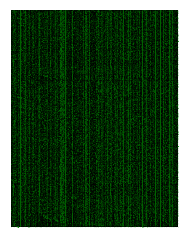

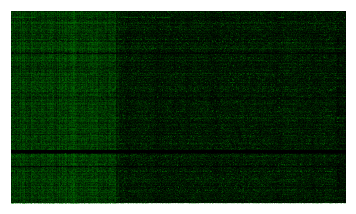

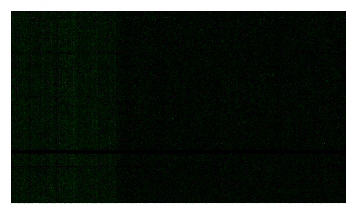

In [8]:
def plot_matrices():
    # Green dots on black background
    d = Data()
    d.build_URMs(k = 5)
    d.build_ICM()
    print(d.URM_train.nnz)


    ax = plot_coo_matrix(d.ICM)
    ax.figure.show()

    ax = plot_coo_matrix(d.URM_train)
    ax.figure.show()

    ax = plot_coo_matrix(d.URM_test)
    ax.figure.show()
plot_matrices()





In [9]:
class Recommender(object):
    def __init__(self, URM_train, URM_test, target_tracks_filter, ICM = None, ISM = None, shrinkage = 0, export = False):
        self.URM_train = URM_train
        self.URM_train_csc = check_matrix(URM_train, 'csc')
        self.ICM = ICM
        self.ttf = target_tracks_filter
        self.ISM = ISM
        self.shrinkage = shrinkage
        self.URM_test = URM_test
        self.export = export
        self.URM_target = self.URM_train_csc[:,self.ttf].tocsr()

        
    def fit(self, reuse_ISM = True, reuse_URM = True): 
        print("Fitting..")
        starttime = time.time()
        cp = time.time()
        
        if self.ISM is None:
            # Compute ISM (I x I)
            
            #ICM must be csc in normalization
            self.ICM = self.normalize(self.ICM)
            # we need ISM to be csr. 
            # although, csc is faster for column wise filtering, which will be done later. 
            if not isinstance(self.ICM, sps.csr_matrix):
                print("Warning, self.ICM not csr format!")
                print("In order for ISM to be csr, ICM must also be csr!")

            # This function saves the ISM to disk instead of keeping it in RAM. 
            if not reuse_ISM: 
                m.dot(self.ICM, self.ICM.T, "h5/ISM.h5", 'csc')
                print("Computed ISM %s sec"%(time.time()-cp))
                cp = time.time()
            
            self.ISM = m.get_result("h5/ISM.h5", 100000, 100000, 'csc')
            print("Loaded ISM %s sec"%(time.time()-cp))
            #self.ISM = self.ICM * self.ICM.T
            cp = time.time()
            
            #print("Saving ISM..")
            #sps.save_npz("Saved Matrixes/ISM_perfect_float_1000", self.ISM)
            #print("Saved ISM! %s sec."%(time.time()-cp))
            cp = time.time()
        else:
            print("Using preloaded ISM. ")
    
        
        # and apply the shrinkage
        if self.shrinkage > 0:
            self.ISM = check_matrix(self.ISM, 'csc')
            # Might get weird if ICM and ISM are different formats?
            print("Applying shrinkage")
            self.ISM = self.apply_shrinkage(self.ISM)  
            print("Applied shrinkage %s sec. "%(time.time()-cp))
        
        # Time to forget the ICM. Not sure if it helps tho. 
        self.ICM = None
        
        cp = time.time()
        
        #Convert to csc in order to filter the columns.
        if isinstance(self.ISM, sps.csc_matrix):
            print("ISM is csc, not need to convert!")
        else: 
            print("Convert ISM to csc. ")
            self.ISM = check_matrix(self.ISM, 'csc')
        
        # Filter: only targeted tracks ISM_target (I x tI) --> set others to 0. 
        self.ISM = self.ISM[:,0:32194]
        print("Filtered untargeted tracks. %s sec" %(time.time()-cp))
        print("ISM_target: I x tI %s %s. " %self.ISM.shape)
        cp = time.time()
        
        # Compute URM (U x I) x ISM_target (I x tI) = pred (U x tI)
        
        # Maybe this conversion is unnecessary? 
        #self.ISM_target = check_matrix(self.ISM_target, 'csr')
        if not reuse_URM:    
            m.dot(self.URM_train, self.ISM, 'h5/URM_pred.h5', 'csr')
            print("Computed predictions. %s sec" %(time.time()-cp))
        self.ISM = None
        self.URM_pred = m.get_result('h5/URM_pred.h5', d.playlists_final.shape[0]-1, d.target_tracks.shape[0], 'csr')
        print("Loaded URM_pred")
        #self.URM_pred = self.URM_train * self.ISM_target
        print("URM_pred: U x tI %s %s. " %self.URM_pred.shape)
        
        # Model is now fitted
    
        print("Model fitted in %s sec."%(time.time()-starttime))
    
    def top_k(self, M, k):
        # Takes Matrix (should probably be CSR). Not used currently.
        if not isinstance(M, sps.csr_matrix):
            print("M not CSR in tok_K function.")
        
        #mask = np.zeros(M.shape, dtype = bool)
        rows = np.zeros((k*M.shape[0],), dtype = int)
        cols = np.zeros((k*M.shape[0],), dtype = int)
        vals = np.ones((k*M.shape[0],), dtype = int)
        
        M = check_matrix(M, 'csr')
        
        for i, track_similarities in enumerate(M): #Kanske inte funkar? 
            # Get top K indices
            top_k_idx = np.argsort(track_similarities)[-k:]
            # Create filter
            rows[k*i:(k+1)*i] = [i]*k
            cols[k*i:(k+1)*i] = top_k_idx
            
        mask = sps.coo_matrix((vals, (rows, cols)), dtype = int).to_csr()
        
        return M[mask]
            
            
    def apply_shrinkage(self, ISM):
        
        # Create an indicator version of the ICM (this is the ICM in our case)
        
        # Multiply ICM_ind with ICM_ind.T (this is the ISM in our case) --> We do not need to deal with the ICM. 
        
        # Remove diagonal (let's skip that, probably not necessary.)
        
        # Compute the shrinkage factor: ISM / ISM + shrinkage
        
        # create an "indicator" version of X (i.e. replace values in X with ones)
        # compute the co-rated counts
        #Would normally be this row: co_counts = X_ind * X_ind.T
        # remove the diagonal
        #co_counts = co_counts - sps.dia_matrix((co_counts.diagonal()[scipy.newaxis, :], [0]), shape=co_counts.shape)
        # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
        # then multiply dist with it
        co_counts_shrink = ISM.copy()
        co_counts_shrink.data += self.shrinkage
        co_counts.data = ISM.copy()
        co_counts.data /= co_counts_shrink.data
        ISM.data *= co_counts.data
        return ISM
    
   # def apply_shrinkage(self, X, dist):
   #     # create an "indicator" version of X (i.e. replace values in X with ones)
   #     X_ind = X.copy()
   #     X_ind.data = np.ones_like(X_ind.data)
   #     # compute the co-rated counts
   #     co_counts = X_ind * X_ind.T
   #     # remove the diagonal
   #     co_counts = co_counts - sps.dia_matrix((co_counts.diagonal()[scipy.newaxis, :], [0]), shape=co_counts.shape)
   #     # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
   #     # then multiply dist with it
   #     co_counts_shrink = co_counts.copy()
   #     co_counts_shrink.data += self.shrinkage
   #     co_counts.data /= co_counts_shrink.data
   #     dist.data *= co_counts.data
   #     return dist
    
    def normalize(self, X):
        Xsq = X.copy()
        Xsq.data **= 2
        norm = np.sqrt(Xsq.sum(axis=0))
        norm = np.asarray(norm).ravel()
        norm += 1e-6
        # compute the number of non-zeros in each column
        # NOTE: this works only if X is instance of sparse.csc_matrix
        col_nnz = np.diff(X.indptr)
        # then normalize the values in each column
        print(norm.shape)
        print(col_nnz.shape)
        X.data /= np.repeat(norm, col_nnz)
        return X
    
    def recommend(self, playlist_idx, k = 5):
        k = 5
        predictions = r.URM_pred[playlist_idx,:].todense()
        #print("Predictions: ")
        #print(predictions)

        #print("Seen indices: ")
        rows, seen_idx, seen_vals = sps.find(r.URM_train[playlist_idx, :])
        #print(seen_idx)

        #print("Seen vals: ")
        #print(predictions[0,seen_idx[seen_idx < 32195]])

        #print("Sorted Prediction idx: ")
        sort_pred_idx = np.argsort(predictions)
        #print(sort_pred_idx[0,-5:])

        #print("Sorted Prediction vals: ")
        #print(predictions[0,sort_pred_idx[0,-5:]])

        #print("Unseen predictions")
        unseen_predictions = predictions
        unseen_predictions[0,seen_idx[seen_idx < 32195]] = 0.0
        #print(unseen_predictions[0,-5:])

        #print("Sorted, Unseen Predictions: ")
        sort_pred_unseen_idx = np.argsort(unseen_predictions)
        #print(sort_pred_unseen_idx[0,-5:])

        #print(unseen_predictions[0, 8945])

        #print("Values of Sorted Predictions: ")
        #print(unseen_predictions[0,sort_pred_unseen_idx])

        #print("Top k unseen prediction idx: ")
        rec_idx = [0]*5
        for i in range(k): 
            idx = sort_pred_unseen_idx[0,-i-1]
            rec_idx[i] = idx
        #print(rec_idx)

        #print("Top k unseen prediction ids: ")
        rec = [0]*5
        for i,idx in enumerate(rec_idx): 
            rec[i] = T.get_track_id(idx)
        #print(rec)
        return rec
    
    
    def get_recommendations(self): 
        zeros = np.zeros((d.target_playlists.size, 6), dtype = int)
        recommendations = pd.DataFrame(zeros)
        recommendations.columns = ['playlist_id', 1, 2, 3, 4, 5]
        counter = 0
        starttime = time.time()
        
        print("URM_pred has dimensions: %s %s"%(self.URM_pred.shape))
        
        for playlist_id in d.target_playlists['playlist_id']:

            if counter % 1000 == 0: 
                print ("%s out of 10000 playlists, %s sec." %(counter, time.time()-starttime))

            playlist_idx = T.get_playlist_idx(int(playlist_id))
            recommendations.iloc[counter, 1:6] = self.recommend(playlist_idx, 5)
            recommendations.iloc[counter, 0] = playlist_id
            counter += 1
        self.recommendations = recommendations
        return self.recommendations
    

    

In [10]:
#Evaluation functions
class Evaluator(object): 
    def __init__(self): 
        self.failed_count = 0
        self.failed_idx = []
        self.hits = 0

    def MAP(self, recommended_items, relevant_items, k = 4):
        map_score = 0.0
        rel_count = 0
        for i in range(k): 
            item = recommended_items[i]
            if item in relevant_items: # item is relevant
                rel_count += 1
                self.hits += 1
                map_score += (1 * 1/(4)) * rel_count/(i+1)
        return map_score



    def evaluate(self, URM_test, recommendations, k=4):
        map_score = 0.0
        rel = np.zeros(5)
        for playlist_id, rec1, rec2, rec3, rec4, rec5 in recommendations.values: 
            playlist_idx = T.get_playlist_idx(playlist_id)
            rec = np.array([rec1, rec2, rec3, rec4, rec5])
            a,b,c = sps.find(URM_test[playlist_idx, :])
            rel_idx = b
            
            for i, idx in enumerate(rel_idx): 
                rel[i] = T.get_track_id(idx)
            
            this_map_score = self.MAP(rec, rel)

            map_score += this_map_score
            
            if this_map_score == 0.0: 
                self.failed_count += 1
                self.failed_idx.append(playlist_id)
            
        avg_map = map_score/recommendations.shape[0]
        avg_hits = self.hits/recommendations.shape[0]
        
        print("Recommender performance is: MAP =%s, Hits: %s, Playlists with no hits: %s" %(round(avg_map, 6), avg_hits, self.failed_count))
        res = ("%s,%s,%s,%s,%s"%(top_k, shrinkage,round(avg_map, 6), avg_hits, self.failed_count))
        print(res)
        return res
        
        



In [11]:
pt()
top_k = 5000

d = Data(random_indexing = True)
d.build_URMs(k = 0)
d.build_ICM()
d.build_target_filter()
#d.load_ISM('Saved Matrixes/ISM_top_k_%s_csr.npz'%(top_k))

#d.ICM = sps.load_npz("Saved Matrixes/ICM_perfect.npz")
d.ISM = None

#    def __init__(self, URM_train, URM_test, target_tracks_filter, ICM = None, ISM = None, shrinkage = 0, export = False):


8:50
Created 57561 indexes for 57561 playlists.
1
1040522
1040523, 1040522
Splitted 1 from 45649 playlists. 2.1906284913141582e-05 
0
Built ICM (csr) with dimensions: Item (100000) x Content (77042) 
Built target filter with shape 100000 


In [12]:
shrinkage = 0
pt()

r = Recommender(URM_train = d.URM_train, 
                URM_test = d.URM_test, 
                target_tracks_filter = d.ttf,
                ICM = d.ICM,
                ISM = d.ISM,
                shrinkage = shrinkage)

8:50
Converting into csc, might be inefficient!


In [13]:
pt() 
r.fit(True, False)

8:50
Fitting..
(77042,)
(77042,)
Warning, self.ICM not csr format!
In order for ISM to be csr, ICM must also be csr!
Loaded ISM 96.66830706596375 sec
ISM is csc, not need to convert!
Filtered untargeted tracks. 120.25686764717102 sec
ISM_target: I x tI 100000 32194. 
Heading into loop. 53.286229848861694 sec
Row 0 out of 57560, 6.993611653645833e-07 min.
Row 500 out of 57560, 1.3489856958389281 min.
Row 5000 out of 57560, 10.602169481913249 min.
Row 10000 out of 57560, 12.040508651733399 min.
Row 15000 out of 57560, 11.943036750952404 min.
Row 20000 out of 57560, 11.775476749738058 min.
Row 25000 out of 57560, 11.892347355683645 min.
Row 30000 out of 57560, 12.147020785013835 min.
Row 35000 out of 57560, 69.10978486935298 min.
Row 40000 out of 57560, 11.66007577975591 min.
Row 45000 out of 57560, 11.703547279040018 min.
Row 50000 out of 57560, 11.658347952365876 min.
Row 55000 out of 57560, 11.773268183072409 min.
Calculated m.dot() to h5/URM_pred.h5. 11773.490953922272 sec
Computed pr

NameError: name 'target_tracks' is not defined

In [15]:
r.URM_pred = m.get_result('h5/URM_pred.h5', d.playlists_final.shape[0]-1, d.target_tracks.shape[0], 'csr')
print("Loaded")

Loaded


57561
32195


In [16]:
pt()
recommendations = r.get_recommendations()
filename = "output/rec_k_%s_shrnk_%s_complete.csv"%(top_k, shrinkage)
np.savetxt(filename ,recommendations, fmt = '%s,%s %s %s %s %s', header = "playlist_id,track_ids", newline = "\n")
print("Saved to file ")

12:26
URM_pred has dimensions: 57560 32195
0 out of 10000 playlists, 0.006693840026855469 sec.
1000 out of 10000 playlists, 4.902754068374634 sec.
2000 out of 10000 playlists, 9.789146900177002 sec.
3000 out of 10000 playlists, 14.697368860244751 sec.
4000 out of 10000 playlists, 19.396219968795776 sec.
5000 out of 10000 playlists, 24.17381191253662 sec.
6000 out of 10000 playlists, 29.28575897216797 sec.
7000 out of 10000 playlists, 34.7902410030365 sec.
8000 out of 10000 playlists, 40.66271996498108 sec.
9000 out of 10000 playlists, 46.52084684371948 sec.
Saved to file 


In [19]:
pt()
e = Evaluator()
res = e.evaluate(d.URM_test, r.recommendations)
with open('stats.csv', 'a') as f: 
    f.write(res+'\n')

1:7
Recommender performance is: MAP =0.018681, Hits: 0.1286, Playlists with no hits: 8874
5000,0,0.018681,0.1286,8874


In [1]:
#ax = plot_coo_matrix(r.ISM)
#ax.figure.show()

1:49
URM_pred has dimensions: 57560 32194
0 out of 10000 playlists, 0.0007650852203369141 sec.
1000 out of 10000 playlists, 3.674800157546997 sec.
2000 out of 10000 playlists, 7.251307010650635 sec.
3000 out of 10000 playlists, 10.893049240112305 sec.
4000 out of 10000 playlists, 14.659285068511963 sec.
5000 out of 10000 playlists, 18.57732605934143 sec.
6000 out of 10000 playlists, 22.919243097305298 sec.
7000 out of 10000 playlists, 27.784712076187134 sec.
8000 out of 10000 playlists, 32.54557490348816 sec.
9000 out of 10000 playlists, 37.321983098983765 sec.
Saved to file 


1:50
Recommender performance is: MAP =0.016215, Hits: 0.1077, Playlists with no hits: 9053
5000,75,0.016215,0.1077,9053


In [81]:
def try_shrinkage(start, stop, stepsize):
    for shrinkage in range(start, stop, stepsize): 
        pt()

        r = Recommender(URM_train = d.URM_train, 
                    URM_test = d.URM_test, 
                    target_tracks_filter = d.ttf,
                    ICM = d.ICM,
                    ISM = d.ISM,
                    shrinkage = shrinkage)

        r.fit()
        recommendations = r.get_recommendations()
        pt()
        e = Evaluator()
        res = e.evaluate(d.URM_test, r.recommendations)
        with open('stats.csv', 'a') as f: 
            f.write(res)
try_shrinkage(100,200,20)

1:56
Converting into csc, might be inefficient!
Fitting..
Using preloaded ISM. 
[ 107.  102.  102. ...,  100.  101.  101.]
[  4.27984959e-03   3.84467538e-04   3.84467538e-04 ...,   0.00000000e+00
   9.80296027e-05   9.80296027e-05]
Applied shrinkage 30.080263137817383 sec. 
Converting into csc, might be inefficient!
Filtered untargeted tracks. 42.446725845336914 sec
ISM_target: I x tI 100000 32194. 
Converting into csr, might be inefficient!
Computed predictions. 21.575461864471436 sec
URM_pred: U x tI 57560 32194. 
Model fitted in 94.10491108894348 sec.
URM_pred has dimensions: 57560 32194
0 out of 10000 playlists, 0.0013229846954345703 sec.
1000 out of 10000 playlists, 5.196638822555542 sec.
2000 out of 10000 playlists, 9.996018886566162 sec.
3000 out of 10000 playlists, 14.723438739776611 sec.
4000 out of 10000 playlists, 19.734336853027344 sec.
5000 out of 10000 playlists, 24.54281187057495 sec.
6000 out of 10000 playlists, 29.254638671875 sec.
7000 out of 10000 playlists, 34.2814

KeyboardInterrupt: 

In [13]:
k = 5
playlist_idx = T.get_playlist_idx(3560810)
predictions = r.URM_pred[playlist_idx,:].todense()
print("Predictions: ")
print(predictions)

print("Seen indices: ")
rows, seen_idx, seen_vals = sps.find(r.URM_train[playlist_idx, :])
print(seen_idx)

print("Seen vals: ")
print(predictions[0,seen_idx[seen_idx < 32195]])

print("Sorted Prediction idx: ")
sort_pred_idx = np.argsort(predictions)
print(sort_pred_idx[0,-5:])

print("Sorted Prediction vals: ")
print(predictions[0,sort_pred_idx[0,-5:]])

print("Unseen predictions")
unseen_predictions = predictions
unseen_predictions[0,seen_idx[seen_idx < 32195]] = 0.0
print(unseen_predictions[0,-5:])

print("Sorted, Unseen Predictions: ")
sort_pred_unseen_idx = np.argsort(unseen_predictions)
print(sort_pred_unseen_idx[0,-5:])

print(unseen_predictions[0, 8945])

print("Values of Sorted Predictions: ")
print(unseen_predictions[0,sort_pred_unseen_idx])


print("Top k seen prediction idx: ")
rec_idx = [0]*5
for i in range(k): 
    idx = sort_pred_unseen_idx[0,-i-1]
    rec_idx[i] = idx
print(rec_idx)
    
print("Top k seen prediction ids: ")
rec = [0]*5
for i,idx in enumerate(rec_idx): 
    rec[i] = T.get_track_id(idx)
print(rec)

print("Top k unseen prediction idx: ")
rec_idx = [0]*5
for i in range(k): 
    idx = sort_pred_unseen_idx[0,-i-1]
    rec_idx[i] = idx
print(rec_idx)
    
print("Top k unseen prediction ids: ")
rec = [0]*5
for i,idx in enumerate(rec_idx): 
    rec[i] = T.get_track_id(idx)
print(rec)

Predictions: 
[[  5.   2.  44. ...,   0.   0.   0.]]
Seen indices: 
[ 1581  1680  1684  1749  4790  5448  6280  6287  6294  6300 11495 11777
 12618 13067 13069 13941 14958 14968 14974 14975 14980 15424 15455 15464
 16355 16360 16367 16369 16371 16378 17988 17993 18015 18026 18027 19130
 21704 22406 22412 22422 27001 27766 33232 33235 33238 36045 41745 42993
 43879 54190 54199 56260 56264 59485 60170 60171 60172 60178 61786 66410
 66963 66968 69510 69518 69526 70221 78439 87749 87750 87751 88309 89008
 91534 91538 95728 95740 96893]
Seen vals: 
[[  57.   96.   74.   79.   77.   69.   60.   71.   58.   58.   56.   71.
    86.   24.   23.   77.  102.   93.   96.   96.   96.   90.   91.   91.
    88.   90.  108.   90.   89.   90.   95.   96.  112.  112.  112.   98.
    89.   62.   60.   57.   52.   18.]]
Sorted Prediction idx: 
[[18037 15479 18012 16023 15040]]
Sorted Prediction vals: 
[[ 134.  134.  134.  136.  169.]]
Unseen predictions
[[ 0.  0.  0.  0.  0.]]
Sorted, Unseen Predictions: 

In [14]:
# Does the recommender rec just targeted tracks? 
def test_all_rec_in_target(recommendations):
    tt = d.target_tracks.values
    recommendations = recommendations.as_matrix()
    yescount = 0
    count = 0
    for row in recommendations: 
        for item in row[1:6]: 
            count += 1
            if item in tt: 
                yescount += 1
                #print("Rec not in target! %s" %item)
    print("%s out of %s were in the target." %(yescount, count))
    
test_all_rec_in_target(recommendations)

50000 out of 50000 were in the target.


NameError: name 'd' is not defined